# P4: Landmarks, Data Association, and SLAM

Instructions the same as they have been. You may need to install a few more packages:

```
pip3 install scipy opencv-python gtsam
```

## P4.1 Triangulation 

In class, we discussed how you could extract information about a 3D scene given two cameras and their camera projection matrices. Here, we will investigate a simple example to learn the fundamentals.

### P4.1.1 Projecting Into Image Space

Below, I have provided you with two images taken by two cameras `a` and `b`. In this question, we will go over some camera basics, namely how to compute the image-space point from a 3D point in the scene and the known camera matrices.

Some information about the two camera matrices:
- The first camera is translated such that `t_a = [0, -0.2, 5]` and `t_b = [-1.5, 0, 5]`
- No rotation is applied to either camera (so the rotation matrix is the identity matrix)
- The focal length of the camera (for these 1024 px) images is `f = 1170.3` (in units of pixels).
- The camera center is located at the center of the image.

**QUESTION** What are the camera matrices $P_a$ and $P_b$? I will accept either the final matrix, or the matrix written in terms of its component matrices (the intrinsic and extrinsic matrices), as long as these are explicitly defined.

I have provided you with a single point below in 3D space `X0` that exists on one of the corners of the cube shown in the scene.

**TASK + PLOTS** Implement the function `get_projected_point(P, X)` which takes in a camera matrix `P` and a 3D scene point `X`. If your matrices are implemented correctly, you should see that the projected 3D point overlaps with one of the corners of the cube in image space. Include the two images with the point `X0` projected onto the two images.

In [ ]:
!pip3 install scipy opencv-python gtsam

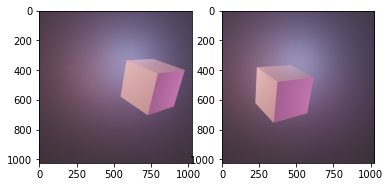

In [4]:
## Starter code
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy

def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    img = np.asarray(img).astype(float)/255
    return img[:, :, :3]

image_a = load_image('two_view_cube_image_a.png')
image_b = load_image('two_view_cube_image_b.png')
plt.figure()
plt.subplot(121)
plt.imshow(image_a)
plt.subplot(122)
plt.imshow(image_b)

None

In [7]:
# TASK: Implement the camera matrices & get_projected_point
# f = 1137.8
f = 1170.3
t_a = np.array([0., -0.2, 5.])
t_b = np.array([-1.5, 0., 5.])
X0 = np.array([ 0.85244616, 0.9508618, -0.51819406])
# X0 = np.array([1.85764703, -0.24689883, -0.25176242 ])
# X0 = np.array([1.74420064, 0.77509012, 0.20990598])
points_3D = [X0]

def get_projected_point(P, X):
    X = np.append(X, 1.)
    T =  P @ X
    return T/T[2]

[734.59280174 708.06684812   1.        ]
[342.9091761  760.29133154   1.        ]


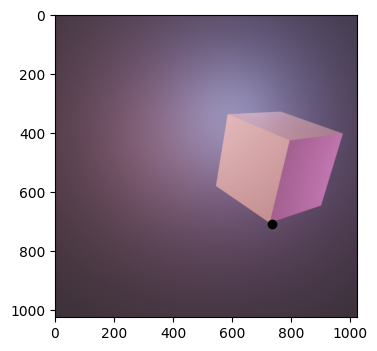

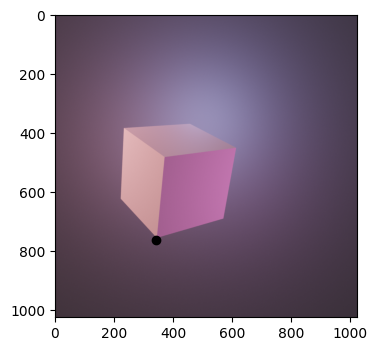

In [8]:
## Plotting Code
Pa = None
Pb = None
if Pa is None or Pb is None:
    Ka = np.array([[f, 0., 512.],
                   [0., f, 512.],
                   [0., 0., 1.]])
    # print(Ka)
    Rt_a = np.array([[1., 0., 0., t_a[0]],
                     [0., 1., 0., t_a[1]],
                     [0., 0., 1., t_a[2]]])
    Pa = Ka @ Rt_a
    # print(Rt_a)

    Kb = np.array([[f, 0., 512.],
                   [0., f, 512.],
                   [0., 0., 1.]])
    # print(Kb)
    Rt_b = np.array([[1., 0., 0., t_b[0]],
                     [0., 1., 0., t_b[1]],
                     [0., 0., 1., t_b[2]]])
    # print(Rt_b)
    Pb = Kb @ Rt_b

def visualize_projected_points(image, P, points_3D, verbose=False):
    plt.figure(dpi=100)
    plt.imshow(image)
    for X in points_3D:
        x = get_projected_point(P, X)
        # print(x)
        if verbose:
            print(x)
        plt.plot(x[0], x[1], 'ko')

visualize_projected_points(image_a, Pa, points_3D, True)
visualize_projected_points(image_b, Pb, points_3D, True)

### P4.1.2 Determining the Size of the Cube

Now you will invert this operation. In class, we discussed how to triangulate a point from two correspondences. The relevant slide from L15 (two-view modeling) is as follows:

<img src="triangulation_lin_alg.png" width="400">

(*Note*: I have used `Pa` and `Pb` to denote the image matrices, whereas the included slide uses $p$ and $p'$.) You can use SVD to solve for the "best" value of the 3D point $X$ (equivalently, you can find the minimum eigenvector of $A^T A$). Manually determine the (x, y) coordinates of two corners in the provided images (from the upper left corner) and use them as part of this triangulation procedure. By finding the 3D point corresponding to two of the corners and computing the distance between them, you should be able to compute the size of the cube in the images.

**TASK** Pick two corners of the cube and include the $(x, y)$ image coordinates for both `image_a` and `image_b` and the 3D world coordinate $(X, Y, Z)$ in your writeup.

**QUESTION** What is the side length of the cube shown in the two images above? (The answer might be somewhat sensitive to the coordinates you measure in image space, though we are only looking for a "close enough" number within maybe 10%–20% of the "correct" answer. You should feel free to use more than two points and average the results to get a more accurate result.)

You can confirm that your estimated 3D coordinates are correct by reprojecting them back into image space using your solution from the previous question to check for accuracy.

> **We will use your full response to evaluate partial credit, so be sure to enumerate the steps you took and (if you feel it helpful) intermediate results or code snippets.**


In [30]:
p1_a = [970,403]
p1_b = [603,450]

p2_a = [905,655]
p2_b = [565,672]

def get_3D_coordinate(Pa, Pb, point_a, point_b):
    row1 = point_a[1]*Pa[2] - Pa[1]
    row2 = Pa[0] - point_a[0]*Pa[2]
    row3 = point_b[1]*Pb[2] - Pb[1]
    row4 = Pb[0] - point_b[0]*Pb[2]   
    A = np.array([row1, row2, row3, row4])
    _,_, v = np.linalg.svd(A, full_matrices=True)
    return v[3]/v[3,3]

X1 = get_3D_coordinate(Pa, Pb, p1_a, p1_b)
print(X1)
X2 = get_3D_coordinate(Pa, Pb, p2_a, p2_b)
print(X2)

# np.array([ 0.85244616, 0.9508618, -0.51819406])
# [734.59280174 708.06684812   1.        ]
# [342.9091761  760.29133154   1.        ]
# p1_c = [734.6, 708.1]
# p2_c = [342.9, 760.3]
edge = np.sqrt(np.square(X1[0]-X2[0])+np.square(X1[1]-X2[1])+np.square(X1[2]-X2[2]))
print(edge) 
V = edge*edge*edge
print(V)

[ 1.87269315 -0.2496902  -0.21355011  1.        ]
[1.74420064 0.77509012 0.20990598 1.        ]
1.116243739836805
1.3908397966427377


### P4.1.3 Incorporating Noise (Pt. 1)

While you can identify roughly where the point is located, it's unlikely that you will pick the corner point exactly. Your measurements are *noisy*. What if we were to incorporate uncertianty into our measurements? 

For this question, assume that your measurements have a Gaussian noise with a standard deviation of 5 pixels. It is the goal of this question to compute the mean and covariance of the for points in 3D space.

**QUESTION** (3-8 sentences) Describe a procedure for how you would compute the mean and covariance of the 3D position of the corner of the cube given the noise model defined above. Note: there might not be an analytic formula for these, so an algorithmic and/or approximate solution is acceptable. You may find the documentation for `numpy.cov` to be helpful: https://numpy.org/doc/stable/reference/generated/numpy.cov.html

**TASK** Implement your procedure.

**CODE** Include your code in your writeup.

**ANSWER** Include your result (the mean and 3D covariance matrix) for two of the points.

**QUESTION** (2-4 sentences) Why might the mean of this result differn from the value you computed in the previous question?

In [34]:
# The function to get mean and covariance of 3D points
import random

def get_mean_cov_3D(Pa, Pb, m1, m2):
    coor_3D = []
    for jj in range(50):
        x1 = m1[0] + random.randint(-5, 5)
        y1 = m1[1] + random.randint(-5, 5)
        x2 = m2[0] + random.randint(-5, 5)
        y2 = m2[1] + random.randint(-5, 5)
    
        X = get_3D_coordinate(Pa, Pb, [x1,y1], [x2,y2])
        coor_3D.append(X[:3])
    coor_3D = np.array(coor_3D).T
    mu_3D = np.mean(coor_3D, axis=1)
    cov_3D = np.cov(coor_3D)
    return mu_3D, cov_3D

In [32]:
p1_a = [970,403]
p1_b = [603,450]

mu1, cov1 = get_mean_cov_3D(Pa, Pb, p1_a, p1_b)
print("The mean of the first corner: ")
print(mu1)
print("The covariance of the first corner: ")
print(cov1)
print()
p2_a = [905,655]
p2_b = [565,672]
mu2, cov2 = get_mean_cov_3D(Pa, Pb, p2_a, p2_b)
print("The mean of the second corner: ")
print(mu2)
print("The covariance of the second corner: ")
print(cov2)

The mean of the first corner: 
[ 1.87367668 -0.24858869 -0.20082316]
The covariance of the first corner: 
[[ 3.09303205e-04 -8.83000307e-05  8.97894108e-04]
 [-8.83000307e-05  9.99873452e-05 -3.26687165e-04]
 [ 8.97894108e-04 -3.26687165e-04  3.50105825e-03]]

The mean of the second corner: 
[1.74334207 0.77385069 0.19595061]
The covariance of the second corner: 
[[0.00039142 0.00021111 0.00130572]
 [0.00021111 0.00020566 0.00088397]
 [0.00130572 0.00088397 0.00598238]]


### P4.1.4 Incorporating Noise (Pt. 2)

Let's next consider how this uncertainty impacts our estimate of the size of the cube.

**QUESTION** (3-8 sentences) Describe a procedure for how you would compute the mean and variance of the length of a side of the cube from observations of two of the corners and the noise model from above.

**TASK** Implement your procedure.

**CODE** Include your code in your writeup.

**ANSWER** Include your result in your writeup: the mean and (1D) variance for the length of the cube.

In [35]:
def get_mean_var_distance(m1, cov1, m2, cov2):
    dis_mu = np.sqrt(np.sum( np.square(m_p1-m_p2) for (m_p1, m_p2) in zip(m1, m2)) )
    var1 = 2*np.square(m1[0] - m2[0])*(np.square(cov1[0,0]) + np.square(cov2[0,0]))
    var2 = 2*np.square(m1[1] - m2[1])*(np.square(cov1[1,1]) + np.square(cov2[1,1]))
    var3 = 2*np.square(m1[2] - m2[2])*(np.square(cov1[2,2]) + np.square(cov2[2,2]))
    var = np.sqrt((var1+var2+var3)/np.square(dis_mu))
    return dis_mu, var

In [36]:
# Running the code
dis_mu, var = get_mean_var_distance(mu1, cov1, mu2, cov2)
print("The average distance: ")
print(dis_mu)
print("The variance: ")
print(var)

The average distance: 
1.1044450285544116
The variance: 
0.0035353120387291814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


## P4.2 Simple Simultaneous Localization and Mapping

Now, we're going to start putting some concepts together and use `gtsam` to both localize the robot and simultaneously track landmarks spread throughout the environment.

I have given you some code below that generates observations from points in the environment. Each observation is a series of detections of nearby landmarks (just points in space for this example): each detection is a 3-element vector of the relative x and y coordinates and the ID of the detected landmark; we assume for now that in addition to the (noisy) relative position of the landmark, we also know which landmark it is, an assumption we will relax in the next part of the assignment.

Run the code below to see what these noisy observations look (blue) like compared to the true landmarks (pale magenta):

relative x,     relative y,  id#
[[-12.0337581    4.1253265    6.        ]
 [ -4.55403443   7.67678622  20.        ]
 [ -3.98527384 -13.6187253   23.        ]
 [  5.56355854   2.65296224  66.        ]
 [  2.02663489   5.73521829  76.        ]]


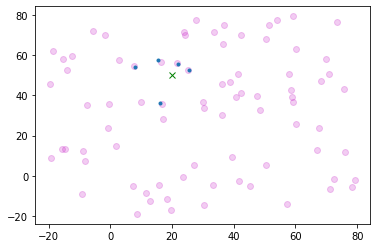

In [37]:
import numpy as np
import matplotlib.pyplot as plt
# from common import Pose
from __init__ import Pose

np.random.seed(1234)

num_landmarks = 80
landmarks = np.array(list(zip(
    100 * np.random.rand(num_landmarks) - 20,
    100 * np.random.rand(num_landmarks) - 20,
    np.arange(num_landmarks))))

def get_observation(pose, range_limit=15, noise_sigma=0.5):
    distances = np.linalg.norm(landmarks[:,:2] - np.array([pose.x, pose.y]), axis=1)
    ego_landmarks = landmarks[distances < range_limit] - np.array([pose.x, pose.y, 0])
    ego_landmarks[:, :2] += noise_sigma * np.random.normal(size=ego_landmarks[:, :2].shape)
    return ego_landmarks

def plot_observation(pose, observation):
    plt.plot([pose.x], [pose.y], 'gx')
    plt.plot(pose.x + observation[:, 0], 
             pose.y + observation[:, 1], '.')

pose = Pose(20, 50, 0)
observation = get_observation(pose)
print("relative x,     relative y,  id#")
print(observation)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
plot_observation(pose, observation)
None

I have provided you with a function `get_noisy_motion` that simulates the robot moving throughout the environment and, at each time step, collecting noisy observations of the nearby landmarks. The robot does not have any GPS measurements! Instead, we'll rely on the detected landmarks to help us keep track of where we are.

I have given you some starter code below. Your task will be to finish the GTSAM implementation and use it to localize both the robot and the landmarks.

Also, keeping track of all the indices and such between the poses and landmarks can be a hastle, so instead you might consider using the GTSAM `symbol` classes: `X` and `L`, so that you can use `X(2)` to say "pose 2" and `L(5)` for the 5th landmark rather than needing a unique ID for everything (see my starter code below).

### P4.2.1 Motion Only

**TASK** Run the "starter visualization code for landmark SLAM" below so that you can see how the observations look without any SLAM.

Motion of the robot, you should already be familiar with: it matches the question from P3, and relies on `BetweenFactorPoint2` factors to track the robot motion.

**TASK** Add the robot poses and motion to GTSAM (no landmarks). Feel free to use your code from P3 to help you here. 

**PLOT** Plot the resulting motion (with uncertainty elipses) using the plotting code below and include in your writeup. You should see that the motion of the robot draws out roughly a square and that the uncertainty grows as the robot moves counterclockwise around the space.

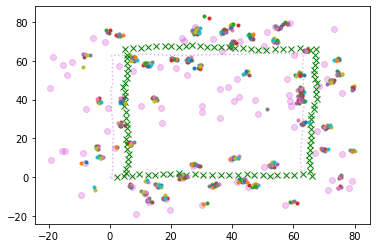

In [38]:
# Starter visualization code for landmark SLAM
import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches

def plot_point2_on_axes(axes, point, P=None, color=None):
    if color is not None:
        axes.plot([point[0]], [point[1]], marker='.', color=color, markersize=8)
    else:
        axes.plot([point[0]], [point[1]], marker='.', markersize=8)
    if P is not None:
        w, v = np.linalg.eigh(P)
        # this corresponds to 95%
        k = 2.447746830681

        angle = np.arctan2(v[1, 0], v[0, 0])
        e1 = patches.Ellipse(point,
                             np.sqrt(w[0]) * 2 * k,
                             np.sqrt(w[1]) * 2 * k,
                             np.rad2deg(angle),
                             fill=False,
                             alpha=0.3)
        axes.add_patch(e1)


def print_result_point2(result):
    for key in result.keys():
        print(f"Point[{key}]:\n"
              f"  Location: {result.atPoint2(key)}, \n"
              f"  Covariance: \n{marginals.marginalCovariance(key)}\n" )

def plot_result_point2(result):
    ax = plt.gca()
    for key in result.keys():
        # print("\nFinal Result:\n{}".format(result.atPoint2(key)))
        plot_point2_on_axes(
            ax, result.atPoint2(key), marginals.marginalCovariance(key))
        
    
    plt.axis('equal')
    plt.show()
    
def get_noisy_motion(do_plot=False):
    np.random.seed(1234)
    steps = 100
    std = 0.2

    # Robot moving generally rightward
    dx_true = np.concatenate(
        [np.random.normal(2.5, 0.2, size=[steps//4]),
         np.random.normal(0.0, 0.2, size=[steps//4]),
         np.random.normal(-2.5, 0.2, size=[steps//4]),
         np.random.normal(0.0, 0.2, size=[steps//4])],
        axis=0)
    dy_true = np.concatenate(
        [np.random.normal(0.0, 0.2, size=[steps//4]),
         np.random.normal(2.5, 0.2, size=[steps//4]),
         np.random.normal(0.0, 0.2, size=[steps//4]),
         np.random.normal(-2.5, 0.2, size=[steps//4])],
        axis=0)

    dx_noisy = dx_true + np.random.normal(0.0, 0.3, size=[steps])
    dy_noisy = dy_true + np.random.normal(0.0, 0.3, size=[steps])

    x_true = np.cumsum(np.concatenate(([0], dx_true), axis=0))
    y_true = np.cumsum(np.concatenate(([0], dy_true), axis=0))
    # print(x_true)
    observations = [get_observation(Pose(xt, yt, 0))
                    for xt, yt in zip(np.cumsum(dx_true), np.cumsum(dy_true))]
    # print("------------------------")
    # print(np.cumsum(dx_true))
    return x_true, y_true, dx_noisy, dy_noisy, observations

x_true, y_true, dx_noisy, dy_noisy, observations = get_noisy_motion(do_plot=True)

# Plot the noisy data
x_noisy = np.cumsum(np.concatenate(([0], dx_noisy), axis=0))
y_noisy = np.cumsum(np.concatenate(([0], dy_noisy), axis=0))
plt.plot(x_true, y_true, ':m', alpha=0.3)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
for ii, (xn, yn, observation) in enumerate(zip(x_noisy[1:], y_noisy[1:], observations)):
    plot_observation(Pose(xn, yn), observation)

None

In [39]:
from gtsam import symbol_shorthand
L = symbol_shorthand.L
X = symbol_shorthand.X

# Create noise models
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1], dtype=float))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3], dtype=float))
LANDMARK_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5], dtype=float))

x_true, y_true, dx_noisy, dy_noisy, observations = get_noisy_motion(do_plot=False)

# print(observations[0])

graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

graph.add(gtsam.PriorFactorPoint2(X(0), gtsam.Point2(0, 0), PRIOR_NOISE))

# Now you do the rest!
initial_estimate.insert(X(0), gtsam.Point2(0,0))
for ii, (x_n, y_n) in enumerate(zip(dx_noisy, dy_noisy)):
    graph.add(gtsam.BetweenFactorPoint2(
        X(ii), X(ii+1), gtsam.Point2(x_n, y_n), ODOMETRY_NOISE))

    initial_estimate.insert(X(ii+1), 
            gtsam.Point2(x_noisy[ii+1]+np.random.normal(0.0, 0.3),
                         y_noisy[ii+1]+np.random.normal(0.0, 0.3)))

    # Adding the landmarks
    for jj, obs in enumerate(observations[ii]):
        if not initial_estimate.exists(L(int(obs[2]))):
            initial_estimate.insert(L(int(obs[2])), gtsam.Point2(50, 50))

        graph.add(gtsam.BetweenFactorPoint2(
            X(ii+1), L(int(obs[2])), gtsam.Point2(obs[0], obs[1]), LANDMARK_NOISE))

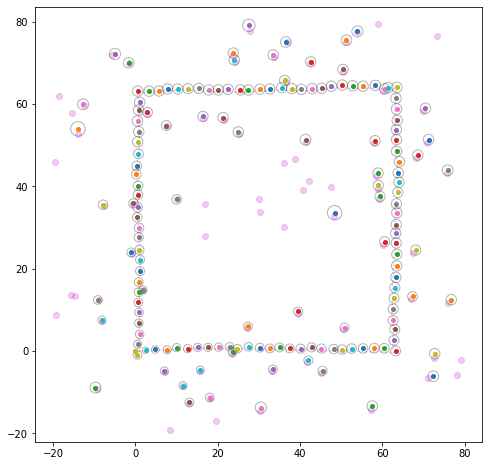

In [40]:
# Parameters for the optimization
parameters = gtsam.GaussNewtonParams()
# parameters = gtsam.LevenbergMarquardtParams()
parameters.setRelativeErrorTol(1e-5)
parameters.setMaxIterations(1000)

optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
# optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, parameters)
result = optimizer.optimize()
marginals = gtsam.Marginals(graph, result)

# print("\nFinal Result:\n{}".format(result))

# Printing and Plotting
plt.figure(figsize=(8, 8))
plt.plot(x_true, y_true, ':m', alpha=0.3)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
# print_result_point2(result)
plot_result_point2(result)

### P4.2.2 Adding Landmarks

**QUESTION** [1-2 sentences] What type of factors relate the landmarks and the poses?

**QUESTION** [2-3 sentences] Are there factors (edges in the graph) between landmarks? If so, what are they? If not, explain why.

**TASK** Using GTSAM, implement landmark SLAM. Add the landmarks and their factors to the graph. Note: you need an initial estimate of the position of the landmarks. Coming up with that can be a bit tricky and, while possible to get a better initial estimate, I suggest you just use [50, 50] for all the landmarks; the optimizer should be able to figure out where everything belongs.

**PLOT** Include the plot showing your result (it should have both the robot poses and the landmarks).

**QUESTION** [3-5 seconds] You may notice that the uncertainty over the positions of some of the landmarks is greater or less than the others. Explain why this may be. Feel free to point to specific examples from your plots.

## P4.3 Data Association

In the last question, we assumed that we knew which detection corresponded to which landmark. Now, we're going to relax that assumption.

### P4.3.1 Naive (Gaussian) Data Association

Here I have provided you with some code that performs very simple data associations: for each detection (in each observation) we compute the likelihood of that point being an observation of an existing landmark. If that probability is within some threshold, it is added as a detection of that landmark, otherwise a new landmark is created.

**TASK** Run the code below and observe the result. You should also seek to understand the code; it will serve as your starting point for the next question. [You do not need to include any plots in your writeup for this question, since I am giving you working code.]

**QUESTION** (2-4 sentences) You may notice that a few of the landmarks (magenta circles) have two observed landmarks (black dots) near them. Explain why this occurs.

**QUESTION** (3-5 sentences) Increase the association threshold from 4 to 16 and observe what happens for the case with perfect positions (the left plot).  Explain what happens and why.

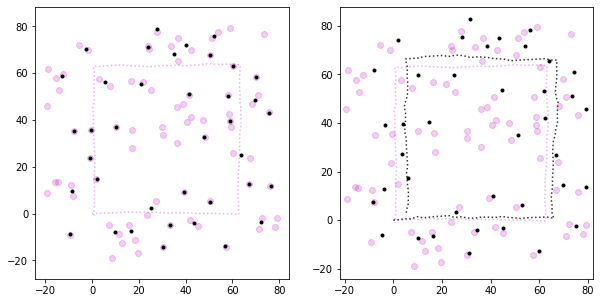

In [49]:
# Data association: initial implementation

class Landmark(object):
    def __init__(self, obs, pose, pose_id):
        # self.position = detection
        self.detections = []
        self.add_detection(obs, pose, pose_id)
        self.update_position()
    
    def add_detection(self, obs, pose, pose_id):
        self.detections.append((obs, pose, pose_id))
        
    def update_position(self):
        self.position = np.mean(
            [obs[:2] + [pose.x, pose.y] for obs, pose, _ in self.detections],
            axis=0
        )

    def prob_of_obs(self, obs, pose, sigma=0.5):
        return np.exp(- ((self.position[0] - pose.x - obs[0])**2 
                         + (self.position[1] - pose.y - obs[1])**2) 
                     / (2 * sigma * sigma))
        
    def log_of_obs(self, obs, pose, sigma=0.5):
        return (- ((self.position[0] - pose.x - obs[0])**2 
                         + (self.position[1] - pose.y - obs[1])**2) 
                     / (2 * sigma * sigma))

def update_landmarks(landmark_set, observation, pose, pose_id, association_thresh=16):
    # Use a simple approach
    for obs in observation:
        probs = [l.prob_of_obs(obs, pose) for l in landmark_set]
        
        if not len(landmark_set) or max(probs) < np.exp(-association_thresh**2/2):
            landmark_set.append(Landmark(obs, pose, pose_id))
        else:
            landmark_set[np.argmax(probs)].add_detection(obs, pose, pose_id)
    for landmark in landmark_set:
        landmark.update_position()
        
# With the true positions
plt.figure(figsize=(10, 5))

x_true, y_true, dx_noisy, dy_noisy, observations = get_noisy_motion(do_plot=True)

plt.subplot(121)
detected_landmarks = []
for ii, (xt, yt, observation) in enumerate(zip(x_true[1:], y_true[1:], observations)):
    update_landmarks(detected_landmarks, observation, Pose(xt, yt), ii+1)

plt.plot(x_true, y_true, ':m', alpha=0.3)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
for l in detected_landmarks:
    plt.plot([l.position[0]], [l.position[1]], 'k.')
plt.axis('equal')


# With noisy positions
plt.subplot(122)
x_noisy = np.cumsum(np.concatenate(([0], dx_noisy), axis=0))
y_noisy = np.cumsum(np.concatenate(([0], dy_noisy), axis=0))
detected_landmarks = []
for ii, (xn, yn, observation) in enumerate(zip(x_noisy[1:], y_noisy[1:], observations)):
    update_landmarks(detected_landmarks, observation, Pose(xn, yn), ii+1)

plt.plot(x_true, y_true, ':m', alpha=0.3)
plt.plot(x_noisy, y_noisy, ':k', alpha=0.8)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
for l in detected_landmarks:
    plt.plot([l.position[0]], [l.position[1]], 'k.')
plt.axis('equal')

None

In [45]:
print(np.exp(-16**2/2))

2.572209372642415e-56


### 4.3.2 Linear Sum Assignment

Unfortunately, matching using the function above has a limitation: it can associate multiple detections *per observation* to the same landmark if two landmarks are close together. This can be an issue if the landmarks tend to be "clumped". If you run the code below, you'll see exactly this behavior.

Instead, we hope to maximize the likelhood of an observation while ensuring that no two detections in a single observation are associated with the same landmark. We can do that using *Linear Sum Assignment* (also often known as the "Hungarian Matching Algorithm"). Here, you will use the scipy implementation of the LSA algorithm to perform data association.

To use the LSA algorithm, we need to define a cost matrix. We are hoping to maximize the likelhiood of a single observation, which is equivalent to minimizing the negative log likelihood of that observation. The benefit of using a logarithm is that while liklihoods multiply, log-likehoods add, allowing us to use linear sum assignment. Each entry in the cost matrix will be the negative log likelihood (as computed by `l.prob_of_obs`) for associating a particular detection with a particular landmark.

The matrix should have a number of rows equal to the number of number of observations. The number of columns is more tricky since you need to allow the landmark to either match to an existing landmark if the likelihood is high enough or to create a new landmark if none of the existing ones is likely. The LSA algorithm does not support "creation of new landmarks", so we'll fake it instead: we add columns with fake landmarks and if the algorithm decides to associate with one of these we make a new landmark instead. This means that the number of columns will be the number of landmarks + the number of observations (since each observation could potentially be 'associated' with a new/fake landmark). While the values of the "left" block of the matrix—corresponding to association with existing landmarks—will have values defined by (though not necessarily equal to) `l.prob_of_obs`, the other elements for association with new landmarks will all have values defined by (though not equal to) the `association_thresh` above. Using this description of the cost matrix, you should be able to implement data association using linear sum assignment.

**TASK** Implement the function `update_landmarks_lsa`, which has the same API as the `update_landmarks` function above. The function should rely on the `scipy.optimize.linear_sum_assignment` to associate detection to landmarks or decide whether a new landmark should be created. (You can `import scipy` for this.)

**CODE** Include the implementation of `update_landmarks_lsa` (or a screenshot of it) in your writeup.

**PLOTS** Include the results plots from the plotting code below in your writeup.

In [46]:
import scipy
from scipy import optimize

In [50]:

def update_landmarks_lsa(landmark_set, observation, 
                  pose, pose_id, association_thresh=4):

    cost_matrix = np.zeros((len(observation), \
                      len(observation)+ len(landmark_set)))
    for ii, obs in enumerate(observation):
        cost_matrix[ii, :len(landmark_set)] = \
              [-l.log_of_obs(obs, pose) for l in landmark_set]
        cost_matrix[ii, len(landmark_set):] = association_thresh**2/2

    row_ind, col_ind = \
              scipy.optimize.linear_sum_assignment(cost_matrix)  

    for jj, (row, col) in enumerate(zip(row_ind, col_ind)):
        if col >= len(landmark_set):
            landmark_set.append(Landmark(observation[row], pose, pose_id))
        else:
            landmark_set[col].add_detection(observation[row], pose, pose_id)

    for landmark in landmark_set:
        landmark.update_position()

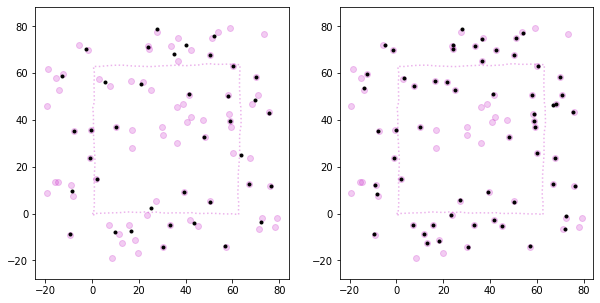

In [54]:
# Without ensuring exclusion
plt.figure(figsize=(10, 5))

x_true, y_true, dx_noisy, dy_noisy, observations = get_noisy_motion(do_plot=True)

plt.subplot(121)
detected_landmarks = []
for ii, (xt, yt, observation) in enumerate(zip(x_true[1:], y_true[1:], observations)):
    update_landmarks(detected_landmarks, observation, Pose(xt, yt), ii+1, association_thresh=16)

plt.plot(x_true, y_true, ':m', alpha=0.3)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
for l in detected_landmarks:
    plt.plot([l.position[0]], [l.position[1]], 'k.')
plt.axis('equal')


# Using a matching algorithm to ensure exclusion
plt.subplot(122)
detected_landmarks = []
for ii, (xt, yt, observation) in enumerate(zip(x_true[1:], y_true[1:], observations)):
    update_landmarks_lsa(detected_landmarks, observation, Pose(xt, yt), ii+1, association_thresh=16)

plt.plot(x_true, y_true, ':m', alpha=0.3)
# plt.plot(x_noisy, y_noisy, ':k', alpha=0.8)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
for l in detected_landmarks:
    plt.plot([l.position[0]], [l.position[1]], 'k.')
plt.axis('equal')
None

## P4.4 SLAM with Noisy Associations

Now we're going to put everything together: SLAM with both odometry and observations of nearby landmarks yet without access to the ground truth data associations. I have provided you with a function `update_positions_gtsam` below that you will complete. The purpose of this function is to take in all the observations so far (including both motion and the landmark observations) and update the poositions of both the robot and the landmarks themselves. I recommend you read through the function to get an idea of how it is intended to work and what's expected of you to complete. Below that function, I have included some plotting code that uses both `update_positions_gtsam` and your data association code to incrementally build a map.

> Note: to keep things simple, you rebuild the entire GTSAM graph each time you receive a new observation. In practice, the graph persists and is built incrementally.

**TASK** Complete the `update_positions_gtsam` code. You should feel free to use your code from earlier, however you should *not rely on the true associations*. Instead, you should use the `Landmark` class that I have given you. Notice that for each landmark, a detection includes not only the position but also the `pose_ind`, the index of the pose at which that observation was collected. You will no doubt find this useful when constructing the `gtsam` graph.

**CODE** Include your completed function (or a screenshot of it) in your writeup.

**PLOT** Include the resulting plot from running the plotting code below in your writeup.

In [ ]:
# Starter Code

def update_positions_gtsam(dxs, dys, observations, landmarks):
    from gtsam import symbol_shorthand
    L = symbol_shorthand.L
    X = symbol_shorthand.X

    # Create noise models
    PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1], dtype=float))
    ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3], dtype=float))
    LANDMARK_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5], dtype=float))

    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()

    graph.add(gtsam.PriorFactorPoint2(X(0), gtsam.Point2(0, 0), PRIOR_NOISE))
    initial_estimate.insert(X(0), gtsam.Point2(0,0))
    x_noisy = np.cumsum(np.concatenate(([0], dxs), axis=0))
    y_noisy = np.cumsum(np.concatenate(([0], dys), axis=0))

    # Add the odometry factors
    for ii, (dx_n, dy_n) in enumerate(zip(dxs, dys)):
        graph.add(gtsam.BetweenFactorPoint2(
            X(ii), X(ii+1), gtsam.Point2(dx_n, dy_n), ODOMETRY_NOISE))    

    # Set the initial estimates for the poses
    for ii, (x_n, y_n) in enumerate(zip(x_noisy, y_noisy)):
        initial_estimate.insert(X(ii+1), gtsam.Point2(x_n, y_n))    

    # Add the observations for the landmarks
    for ii, landmark in enumerate(landmarks):
        # Set the initial position of the landmarks
        initial_estimate.insert(L(ii), 
              gtsam.Point2(landmark.position[0], landmark.position[1]))
        for jj, obs in enumerate(landmark.detections):
            graph.add(gtsam.BetweenFactorPoint2(X(obs[2]), L(ii), 
                  gtsam.Point2(obs[0][0], obs[0][1]), LANDMARK_NOISE))

    
    # Set the initial position of the landmarks
    # Note: you can use the positions already stored in each landmark as an initial guess
    # for ii, landmark in enumerate(landmarks):
    #     initial_estimate.insert(L(ii), 
    #           gtsam.Point2(landmark.position[0], landmark.position[1]))    

    # Parameters for the optimization
    parameters = gtsam.GaussNewtonParams()
    parameters.setRelativeErrorTol(1e-5)
    parameters.setMaxIterations(1000)
    optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
    result = optimizer.optimize()
    marginals = gtsam.Marginals(graph, result)
    
    # Get the values of the landmark positions.
    # Note: you don't need to do it like this, but this is how I've done it.
    # I recommend that you use the "symbols" L and X; it makes bookkeeping easier.
    for lind, l in enumerate(landmarks):
        l.position = result.atPoint2(L(lind))

    return result.atPoint2(X(len(dxs))), result, marginals

1 5 [4.57422555 0.54299547]
2 6 [7.40786645 0.57845017]
3 8 [9.63229299 1.48228012]
4 8 [12.37210998  0.72084051]
5 9 [14.77779962  1.15062098]
6 9 [17.28716359  1.53012107]
7 10 [19.62210758  1.29660342]
8 10 [23.04446388  1.49418286]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


9 10 [24.96061671  0.34835227]
10 12 [27.48076261  0.99002111]
11 13 [29.59781843  0.73350516]
12 14 [32.97946126  1.02252262]
13 14 [35.23695857  1.37376807]
14 15 [37.60383679  1.15179423]
15 15 [40.08926715  0.73848049]
16 15 [42.65745145  1.28436434]
17 15 [44.76376839  0.70487704]
18 15 [47.72337639  0.58891806]
19 15 [50.35516807  0.42286374]
20 15 [52.28642336  0.87780899]
21 16 [55.20467241  1.10554417]
22 16 [57.56508305  1.02778181]
23 19 [60.69462779  1.32344025]
24 19 [63.20249317  0.67756703]
25 19 [62.04583003  2.91879216]
26 20 [62.28017301  6.35643222]
27 20 [62.22921275  8.54307928]
28 20 [62.51663254 10.95673316]
29 22 [62.60121946 13.11877023]
30 22 [62.21508351 15.5340503 ]
31 22 [62.69959986 18.22585224]
32 22 [63.08077726 20.79422571]
33 23 [63.0806917  23.89089035]
34 24 [62.8324353  26.45874361]
35 24 [63.08036606 29.06873057]
36 25 [62.98350423 31.69546579]
37 26 [64.10939212 33.9743886 ]
38 27 [63.69143417 36.12616604]
39 30 [63.84898825 38.99603937]
40 30 [63

IndexError: ignored

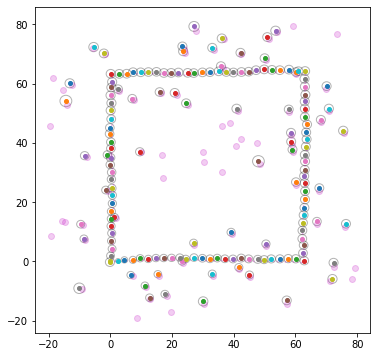

In [ ]:
# plotting and results code

x_true, y_true, dx_noisy, dy_noisy, observations = get_noisy_motion()
detected_landmarks = []
for tind in range(1, len(observations)):
    # Use SLAM to update the robot and landmark positions
    position, result, marginals = update_positions_gtsam(
        dx_noisy[:tind+1], 
        dy_noisy[:tind+1], 
        observations[:tind],
        detected_landmarks)

    # Data association on the landmarks
    update_landmarks_lsa(detected_landmarks, 
                         observations[tind][:, :2], 
                         Pose(position[0], position[1]), 
                         tind+1, 
                         association_thresh=8)

    # Outputs
    print(tind, len(detected_landmarks), position)

# Printing and Plotting
plt.figure(figsize=(6, 6))
plt.plot(x_true, y_true, ':m', alpha=0.3)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'mo', alpha=0.2)
plot_result_point2(result)
None